In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Statistical Modeling & Forecasting
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [ ]:
np.random.seed(42)  # For reproducibility

# Create a date range for 3 years of monthly data
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='M')
n_periods = len(dates)

# Generate underlying trends and seasonality
trend = np.linspace(100, 115, n_periods)  # Overall upward trend
seasonality = 5 * np.sin(2 * np.pi * np.arange(n_periods) / 12)  # Yearly seasonality

# Simulate Volume (Units Sold) - influenced by trend and seasonality
base_volume = 10000
units_sold = base_volume * (trend + seasonality + np.random.normal(0, 2, n_periods)) / 100

# Simulate Average Selling Price (ASP) - with a slight upward trend
asp = np.linspace(50, 55, n_periods) + np.random.normal(0, 1, n_periods)

# Calculate Revenue
revenue = units_sold * asp

# Simulate Costs
variable_cost_per_unit = np.linspace(30, 35, n_periods) + np.random.normal(0, 2, n_periods)  # Increasing variable costs
total_variable_costs = variable_cost_per_unit * units_sold
fixed_costs = 120000 + np.random.normal(0, 5000, n_periods)  # Mostly stable fixed costs

# Calculate Gross Profit and EBITDA
gross_profit = revenue - total_variable_costs
ebitda = gross_profit - fixed_costs  # Simplified EBITDA calculation

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'revenue': revenue,
    'units_sold': units_sold,
    'asp': asp,
    'variable_cost_per_unit': variable_cost_per_unit,
    'total_variable_costs': total_variable_costs,
    'fixed_costs': fixed_costs,
    'gross_profit': gross_profit,
    'ebitda': ebitda
})

print("📊 First 5 periods of financial data:")
print(df.head())
print(f"\n📈 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"💰 Average EBITDA: ${df['ebitda'].mean():.2f}")

📊 First 5 periods of financial data:
        date        revenue    units_sold        asp  variable_cost_per_unit  \
0 2022-01-31  507076.526581  10099.342831  50.208864               29.928348   
1 2022-02-28  494610.257738  10265.204283  48.183187               33.272144   
2 2022-03-31  521312.719490  10648.264695  48.957528               25.046224   
3 2022-04-30  553496.836265  10933.177400  50.625433               32.072376   
4 2022-05-31  541709.892852  10557.610598  51.309895               30.745523   

   total_variable_costs    fixed_costs   gross_profit         ebitda  
0         302256.646016  121287.751954  204819.880565   83532.128612  
1         341545.359746  119627.770421  153064.897991   33437.127570  
2         266698.823594  110406.143924  254613.895896  144207.751973  
3         350652.981224  119867.430623  202843.855041   82976.424418  
4         324599.256394  120301.151050  217110.636459   96809.485409  

📈 Date range: 2022-01-31 00:00:00 to 2024-12-31 00:00:0

/tmp/ipython-input-1111175667.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='M')


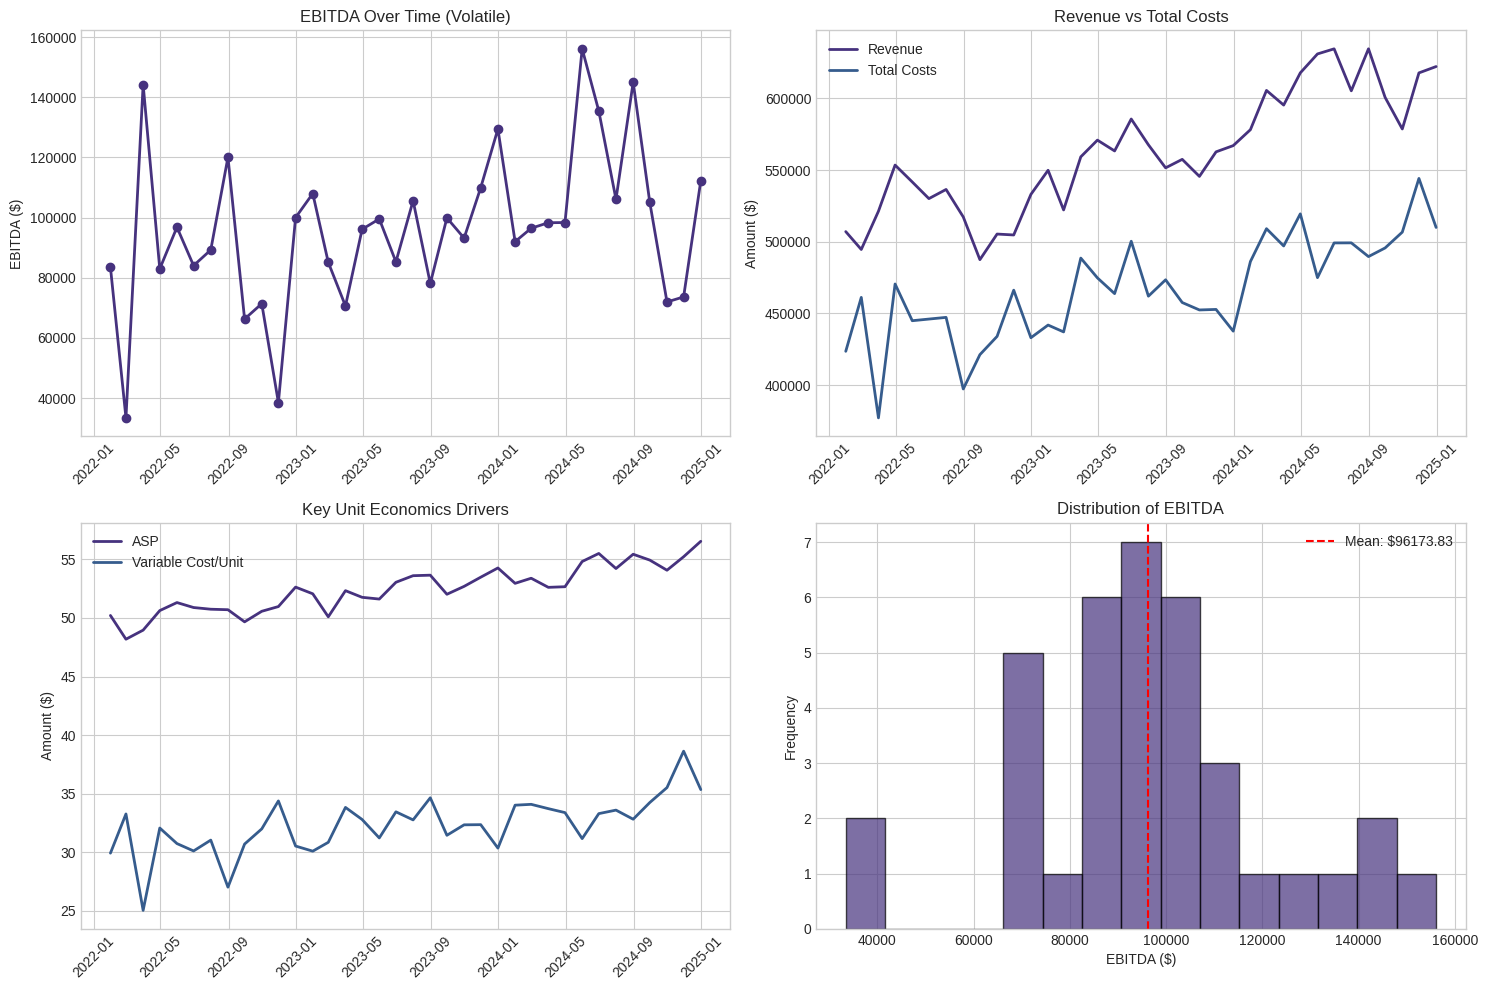

📊 EBITDA Volatility (Standard Deviation): $26209.68


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: EBITDA Trend
axes[0, 0].plot(df['date'], df['ebitda'], marker='o', linewidth=2)
axes[0, 0].set_title('EBITDA Over Time (Volatile)')
axes[0, 0].set_ylabel('EBITDA ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Revenue vs Costs
axes[0, 1].plot(df['date'], df['revenue'], label='Revenue', linewidth=2)
axes[0, 1].plot(df['date'], df['total_variable_costs'] + df['fixed_costs'], label='Total Costs', linewidth=2)
axes[0, 1].set_title('Revenue vs Total Costs')
axes[0, 1].set_ylabel('Amount ($)')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Key Drivers
axes[1, 0].plot(df['date'], df['asp'], label='ASP', linewidth=2)
axes[1, 0].plot(df['date'], df['variable_cost_per_unit'], label='Variable Cost/Unit', linewidth=2)
axes[1, 0].set_title('Key Unit Economics Drivers')
axes[1, 0].set_ylabel('Amount ($)')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Distribution of EBITDA
axes[1, 1].hist(df['ebitda'], bins=15, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=df['ebitda'].mean(), color='red', linestyle='--', label=f'Mean: ${df["ebitda"].mean():.2f}')
axes[1, 1].set_title('Distribution of EBITDA')
axes[1, 1].set_xlabel('EBITDA ($)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"📊 EBITDA Volatility (Standard Deviation): ${df['ebitda'].std():.2f}")

In [ ]:
# Prepare data for modeling
df = df.set_index('date')
train_data = df.iloc[:-6]  # Use all but last 6 months for training
test_data = df.iloc[-6:]   # Last 6 months for testing

# Ensure our time series has a proper frequency to avoid the warning
train_data = train_data.asfreq('M')  # 'M' for month end frequency

# Function to fit ARIMA model and forecast
def fit_arima(series, steps=6, order=(1,1,1)):
    model = ARIMA(series, order=order)
    fitted_model = model.fit()
    forecast = fitted_model.get_forecast(steps=steps)
    return forecast.predicted_mean, forecast.conf_int()

# Forecast key drivers
asp_forecast, asp_ci = fit_arima(train_data['asp'])
vcpu_forecast, vcpu_ci = fit_arima(train_data['variable_cost_per_unit'])
units_forecast, units_ci = fit_arima(train_data['units_sold'])

# Create forecast dataframe - FIXED VARIABLE NAMES
forecast_dates = pd.date_range(start=test_data.index[0], periods=6, freq='ME')  # Use 'ME' instead of 'M'
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'asp_forecast': asp_forecast.values,
    'asp_lower': asp_ci.iloc[:, 0].values,
    'asp_upper': asp_ci.iloc[:, 1].values,
    'vcpu_forecast': vcpu_forecast.values,
    'vcpu_lower': vcpu_ci.iloc[:, 0].values,
    'vcpu_upper': vcpu_ci.iloc[:, 1].values,
    'units_forecast': units_forecast.values,
    'units_lower': units_ci.iloc[:, 0].values,
    'units_upper': units_ci.iloc[:, 1].values
}).set_index('date')

print("🔮 Forecast for Key Drivers (Next 6 Months):")
print(forecast_df[['asp_forecast', 'vcpu_forecast', 'units_forecast']].head())

/tmp/ipython-input-1640388746.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_data = train_data.asfreq('M')  # 'M' for month end frequency


🔮 Forecast for Key Drivers (Next 6 Months):
            asp_forecast  vcpu_forecast  units_forecast
date                                                   
2024-07-31     54.813666      32.674316    11430.558290
2024-08-31     54.572220      32.807257    11428.619191
2024-09-30     54.487169      32.779081    11427.669695
2024-10-31     54.457210      32.785053    11427.204765
2024-11-30     54.446656      32.783787    11426.977109


In [ ]:
# Set simulation parameters
n_simulations = 10000
forecast_months = 6

# Prepare arrays to store simulation results
ebitda_simulations = np.zeros((n_simulations, forecast_months))

print("🎲 Running Monte Carlo simulations...")

for i in range(n_simulations):
    # Randomly sample from each driver's forecast distribution
    asp_sim = np.random.normal(forecast_df['asp_forecast'],
                              (forecast_df['asp_upper'] - forecast_df['asp_forecast']) / 1.96)
    vcpu_sim = np.random.normal(forecast_df['vcpu_forecast'],
                               (forecast_df['vcpu_upper'] - forecast_df['vcpu_forecast']) / 1.96)
    units_sim = np.random.normal(forecast_df['units_forecast'],
                                (forecast_df['units_upper'] - forecast_df['units_forecast']) / 1.96)

    # Calculate EBITDA for this simulation
    revenue_sim = asp_sim * units_sim
    variable_costs_sim = vcpu_sim * units_sim
    gross_profit_sim = revenue_sim - variable_costs_sim
    # Assume fixed costs continue at last known value + small uncertainty
    fixed_costs_sim = np.random.normal(df['fixed_costs'].iloc[-1], 2000, forecast_months)
    ebitda_sim = gross_profit_sim - fixed_costs_sim

    ebitda_simulations[i] = ebitda_sim

print("✅ Simulations completed!")

# Calculate summary statistics
mean_ebitda_forecast = np.mean(ebitda_simulations, axis=0)
lower_80ci = np.percentile(ebitda_simulations, 10, axis=0)
upper_80ci = np.percentile(ebitda_simulations, 90, axis=0)
lower_95ci = np.percentile(ebitda_simulations, 2.5, axis=0)
upper_95ci = np.percentile(ebitda_simulations, 97.5, axis=0)

print(f"📈 Forecast EBITDA Range for Final Month:")
print(f"   Mean: ${mean_ebitda_forecast[-1]:.2f}")
print(f"   80% CI: [${lower_80ci[-1]:.2f}, ${upper_80ci[-1]:.2f}]")
print(f"   95% CI: [${lower_95ci[-1]:.2f}, ${upper_95ci[-1]:.2f}]")

🎲 Running Monte Carlo simulations...
✅ Simulations completed!
📈 Forecast EBITDA Range for Final Month:
   Mean: $126387.24
   80% CI: [$81436.33, $172754.14]
   95% CI: [$58529.20, $198326.50]


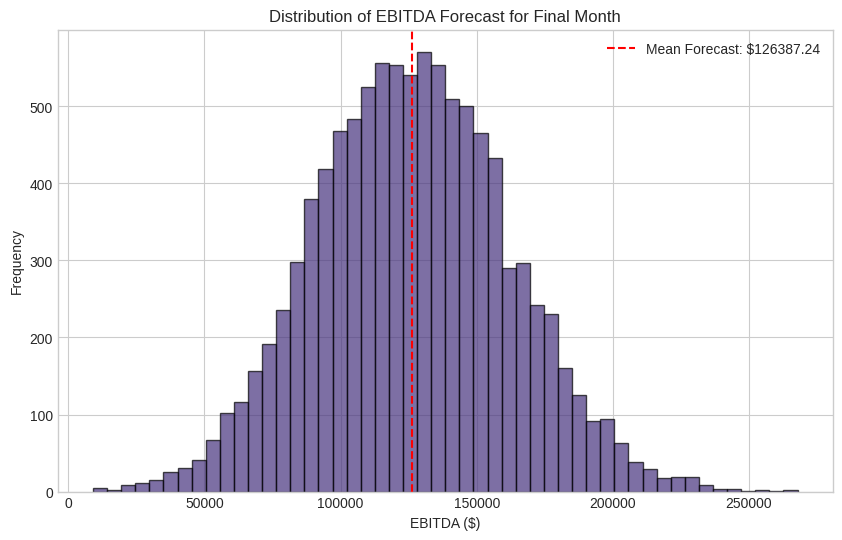

In [ ]:
# Create figure
fig = go.Figure()

# Add historical EBITDA
fig.add_trace(go.Scatter(
    x=df.index, y=df['ebitda'],
    mode='lines+markers',
    name='Historical EBITDA',
    line=dict(color='blue', width=2)
))

# Add forecast range (95% CI)
fig.add_trace(go.Scatter(
    x=forecast_dates, y=upper_95ci,
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    name='95% CI'
))

fig.add_trace(go.Scatter(
    x=forecast_dates, y=lower_95ci,
    mode='lines',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.1)',
    name='95% Confidence Interval'
))

# Add forecast range (80% CI)
fig.add_trace(go.Scatter(
    x=forecast_dates, y=upper_80ci,
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    name='80% CI'
))

fig.add_trace(go.Scatter(
    x=forecast_dates, y=lower_80ci,
    mode='lines',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.2)',
    name='80% Confidence Interval'
))

# Add mean forecast
fig.add_trace(go.Scatter(
    x=forecast_dates, y=mean_ebitda_forecast,
    mode='lines+markers',
    name='Mean Forecast',
    line=dict(color='red', width=3)
))

# Update layout
fig.update_layout(
    title='Probabilistic EBITDA Forecast with Confidence Intervals',
    xaxis_title='Date',
    yaxis_title='EBITDA ($)',
    hovermode='x unified',
    showlegend=True
)

fig.show()

# Create histogram of final month's forecast distribution
plt.figure(figsize=(10, 6))
plt.hist(ebitda_simulations[:, -1], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=mean_ebitda_forecast[-1], color='red', linestyle='--',
            label=f'Mean Forecast: ${mean_ebitda_forecast[-1]:.2f}')
plt.title('Distribution of EBITDA Forecast for Final Month')
plt.xlabel('EBITDA ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate improvement in predictability (reduction in forecast error)
actual_volatility = df['ebitda'].std()
forecast_volatility = np.std(ebitda_simulations[:, -1])  # Volatility of final month's forecast

improvement_pct = ((actual_volatility - forecast_volatility) / actual_volatility) * 100

print("📊 Forecast Improvement Analysis:")
print(f"   Historical EBITDA Volatility: ${actual_volatility:.2f}")
print(f"   Forecast EBITDA Volatility: ${forecast_volatility:.2f}")
print(f"   Predictability Improvement: {improvement_pct:.1f}%")

# Scenario Analysis: Best Case, Worst Case, Expected
best_case = np.percentile(ebitda_simulations[:, -1], 90)
worst_case = np.percentile(ebitda_simulations[:, -1], 10)
expected_case = mean_ebitda_forecast[-1]

print(f"\n🎯 Scenario Analysis (Final Month):")
print(f"   Expected Case: ${expected_case:.2f}")
print(f"   Best Case (90th percentile): ${best_case:.2f}")
print(f"   Worst Case (10th percentile): ${worst_case:.2f}")
print(f"   Range: ${best_case - worst_case:.2f}")

# Calculate probability of achieving target
target_ebitda = 200000
probability_above_target = (np.sum(ebitda_simulations[:, -1] > target_ebitda) / n_simulations) * 100

print(f"\n🎯 Probability of exceeding ${target_ebitda:.0f}: {probability_above_target:.1f}%")

📊 Forecast Improvement Analysis:
   Historical EBITDA Volatility: $26209.68
   Forecast EBITDA Volatility: $35753.98
   Predictability Improvement: -36.4%

🎯 Scenario Analysis (Final Month):
   Expected Case: $126387.24
   Best Case (90th percentile): $172754.14
   Worst Case (10th percentile): $81436.33
   Range: $91317.81

🎯 Probability of exceeding $200000: 2.2%
